# PetFinder.my - Pawpularity Contest

In [1]:
import os
import random

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers import concatenate, Input, BatchNormalization, Dropout, Dense

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Tabular data file paths
TRAIN_DATA_PATH = './data/train.csv'
TEST_DATA_PATH = './data/test.csv'

# Image data directories
TRAIN_DIRECTORY = './data/train'
TEST_DIRECTORY = './data/test'

In [3]:
# Parameters for processing tabular data
TARGET_NAME = 'Pawpularity'
VAL_SIZE = 0.2
SEED = 5

In [4]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 224
BATCH_SIZE = 64
DROPOUT_RATE = 0.4
LEARNING_RATE = 1e-3
DECAY_STEPS = 100
DECAY_RATE = 0.96
EPOCHS = 500
PATIENCE = 5

In [14]:
# Pretrained image classification model EfficientNetB0
# from tf.keras.applications with global average pooling as a final layer.
# In this notebook the model is loaded from a public dataset on Kaggle
# at https://www.kaggle.com/ekaterinadranitsyna/keras-applications-models
IMG_MODEL = './keras-applications-models/EfficientNetB0.h5'

## Functions

In [6]:
def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format


def id_to_path(img_id: str, dir: str):
    """Function returns a path to an image file.
    :param img_id: Image Id
    :param dir: Path to the directory with images
    :return: Image file path
    """
    return os.path.join(dir, f'{img_id}.jpg')


@tf.function
def get_image(path: str) -> tf.Tensor:
    """Function loads image from a file and preprocesses it.
    :param path: Path to image file
    :return: Tensor with preprocessed image
    """
    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE), dtype=tf.int32)
    return image


@tf.function
def process_dataset_train(path: str, x_numeric, y: int) -> tuple:
    """Function returns preprocessed image and label.
    :param path: Path to image file
    :param label: Class label
    :return: tf.Tensor with preprocessed image, numeric label
    """
    
    return {'image_input': get_image(path), 'numeric_input': x_numeric}, y

@tf.function
def process_dataset_test(path: str, x_numeric) -> tuple:
    """Function returns preprocessed image and label.
    :param path: Path to image file
    :param label: Class label
    :return: tf.Tensor with preprocessed image, numeric label
    """
    
    return {'image_input': get_image(path), 'numeric_input': x_numeric}

@tf.function
def get_dataset(x_images, x_numeric, y=None) -> tf.data.Dataset:
    """Function creates batched optimized dataset for the model
    out of an array of file paths and (optionally) class labels.
    :param x: Input data for the model (array of file paths)
    :param y: Target values for the model (array of class indexes)
    :return TensorFlow Dataset object
    """
    if y is not None:
        ds = tf.data.Dataset.from_tensor_slices((x_images, x_numeric, y))
        ds = ds.map(process_dataset_train, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    
        return ds
    else:
        ds = tf.data.Dataset.from_tensor_slices((x_images, x_numeric))
        ds = ds.map(process_dataset_test, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
        
        return ds


def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    # Losses and metrics
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    rmse = hist.history['root_mean_squared_error']
    val_rmse = hist.history['val_root_mean_squared_error']

    # Epochs to plot along x axis
    x_axis = range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    ax1.plot(x_axis, loss, 'bo', label='Training')
    ax1.plot(x_axis, val_loss, 'ro', label='Validation')
    ax1.set_title('MSE Loss')
    ax1.legend()

    ax2.plot(x_axis, rmse, 'bo', label='Training')
    ax2.plot(x_axis, val_rmse, 'ro', label='Validation')
    ax2.set_title('Root Mean Squared Error')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Data Processing

In [7]:
set_seed(SEED)
set_display()

In [8]:
# Train data set
data_train = pd.read_csv(TRAIN_DATA_PATH)
print(f'Train data shape: {data_train.shape}')
data_train.head()

Train data shape: (9912, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
# Test data set
data_test = pd.read_csv(TEST_DATA_PATH)
print(f'Test data shape: {data_test.shape}')
data_test.head()

Test data shape: (8, 13)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [10]:
# Reconstruct the paths to train and test images.
data_train['path'] = data_train['Id'].apply(
    lambda x: id_to_path(x, TRAIN_DIRECTORY))
data_test['path'] = data_test['Id'].apply(
    lambda x: id_to_path(x, TEST_DIRECTORY))

# Keep a portion of the labeled data for validation.
train_subset, valid_subset = train_test_split(
    data_train, #[['path', TARGET_NAME]],
    test_size=VAL_SIZE, shuffle=True, random_state=SEED
)

In [11]:
attributes = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', \
              'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', \
              'Info', 'Blur']

x_train_numeric = train_subset[attributes].to_numpy()
x_valid_numeric = valid_subset[attributes].to_numpy()
x_test_numeric = data_test[attributes].to_numpy()

In [15]:
# Create TensorFlow datasets
train_ds = get_dataset(x_images=train_subset['path'], 
                       x_numeric = x_train_numeric,
                       y=train_subset[TARGET_NAME])
valid_ds = get_dataset(x_images=valid_subset['path'],
                       x_numeric = x_valid_numeric,                       
                       y=valid_subset[TARGET_NAME])

test_ds = get_dataset(x_images=data_test['path'],
                       x_numeric = x_test_numeric)

In [16]:
# Pretrained image classification model
feature_model = tf.keras.models.load_model(IMG_MODEL)

# Freeze weights in the original model
feature_model.trainable = False

In [17]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

## Multiple input
# Image model
input_images = Input(name = 'image_input', shape=(IMG_SIZE, IMG_SIZE, 3))
x = RandomFlip(mode='horizontal')(input_images)
x = feature_model(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE, name='top_dropout')(x)
x = Dense(32, activation='relu')(x)
image_model = Model(inputs = input_images, outputs = x)

# Info model
input_info = Input(name = 'numeric_input', shape=(len(attributes),))
y = Dense(64, activation="relu")(input_info)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
info_model = Model(inputs=input_info, outputs=y)

# combine the output of the two branches
combined = concatenate([image_model.output, info_model.output])

# apply a FC layer and then a regression prediction on the combined outputs
output = Dense(2, activation="relu")(combined)
output = Dense(1, activation="linear", name='score')(output)

# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[image_model.input, info_model.input], outputs=output)

In [39]:
plot_model(model, show_shapes=True, show_layer_names=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [19]:
# To gradually decrease learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE,
    staircase=True)

In [20]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [21]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 224, 224, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 1280)         4049571     random_flip[0][0]                
__________________________________________________________________________________________________
numeric_input (InputLayer)      [(None, 12)]         0                                            
____________________________________________________________________________________________

In [22]:
# To monitor validation loss and stop the training.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

In [23]:
history = model.fit(train_ds, validation_data=valid_ds,
                          epochs=EPOCHS, callbacks=[early_stop],
                          use_multiprocessing=True, workers=-1)

Epoch 1/500
124/124 [==============================] - 477s 4s/step - loss: 760.1365 - root_mean_squared_error: 27.5706 - val_loss: 590.0264 - val_root_mean_squared_error: 24.2905
Epoch 2/500
124/124 [==============================] - 486s 4s/step - loss: 375.5645 - root_mean_squared_error: 19.3795 - val_loss: 425.9248 - val_root_mean_squared_error: 20.6379
Epoch 3/500
124/124 [==============================] - 464s 4s/step - loss: 356.5406 - root_mean_squared_error: 18.8823 - val_loss: 384.5745 - val_root_mean_squared_error: 19.6106
Epoch 4/500
124/124 [==============================] - 465s 4s/step - loss: 347.9537 - root_mean_squared_error: 18.6535 - val_loss: 377.7622 - val_root_mean_squared_error: 19.4361
Epoch 5/500
124/124 [==============================] - 467s 4s/step - loss: 343.5973 - root_mean_squared_error: 18.5364 - val_loss: 376.3206 - val_root_mean_squared_error: 19.3990
Epoch 6/500
124/124 [==============================] - 465s 4s/step - loss: 335.9429 - root_mean_squ

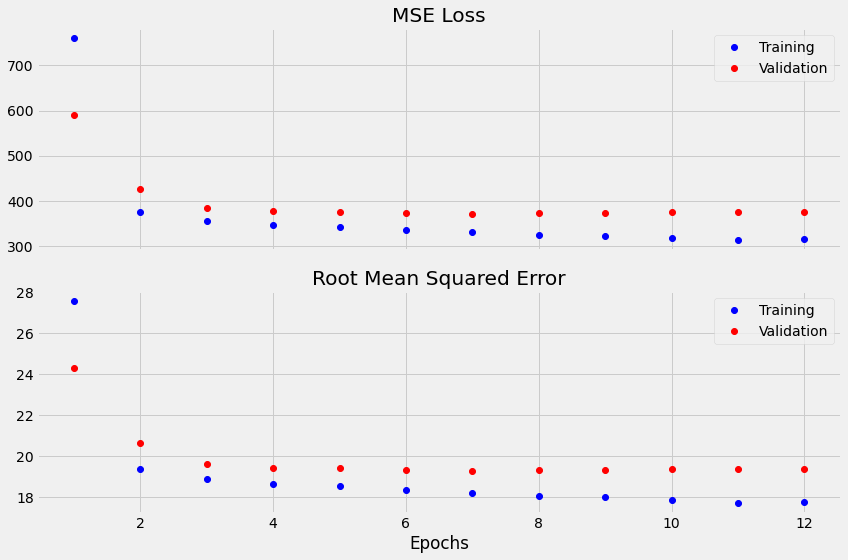

In [24]:
plot_history(history)

## Inference

In [25]:
# Predict popularity score for the test
data_test[TARGET_NAME] = model.predict(
    test_ds, use_multiprocessing=True, workers=os.cpu_count())


In [26]:
data_test[['Id', TARGET_NAME]].to_csv('submission.csv', index=False)
data_test[['Id', TARGET_NAME]].head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,47.5852
1,43a2262d7738e3d420d453815151079e,47.3151
2,4e429cead1848a298432a0acad014c9d,49.7378
3,80bc3ccafcc51b66303c2c263aa38486,40.6961
4,8f49844c382931444e68dffbe20228f4,45.4271
